# Project 3 - Ames Housing Challenge 
## Thomas Brewer - Boston

### *Note (and a bit of a rant) :*
*For this project, I did a lot of tweaking and tuning to try optimizing my models, most of the time to no avail.  For this notebook, I will only be presenting one model. I also attempted to organize the data in a lot of different ways, but I will only show the final way.  Finally, because I'm terrible at time management I mostly focused on the regression challenge.  I don't make any changes to the data when doing classifications*

### *Note II :*
*For my work I made a separate* `tools.py` *file.  These contain various tools I used for visualizations and other things.  I include the relevant functions in this notebook to display things.*

In [1]:
# Before anything, let's import the libraries
# Import libraries

# Basic
import numpy as np
import pandas as pd
import scipy.stats as stats

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# Some tools I made as I went along.
# I'm actually including the relevant functions here but if see tools.py if curious
import tools

# For reloading my libraries, while working on them
from importlib import reload

# So that I stop getting warnings... I know it's bad form, but
# it was annoying =p
import warnings
warnings.filterwarnings('ignore')

## 1) Intro

For this project, we were supplied with the Ames Housing dataset, which lists sale prices, and various features of houses sold over a 4 or 5 years (around 2010).  With these features we had to make two things : <br>
- A Regression Model, to predict sale prices on a different dataset
- A Classification Model to predict the sale condition of the house was
<br><br>
That about sums it up. 

## 2) The Data

The training data set had about 2000 rows, and 80 columns displaying different features.  The features included information such as `SalePrice`, `Neighborhood`, surface area in different parts of the house, etc.  About half of them were numerical features, and the other half categorical.  The idea behind making the model, I guess was finding a good way to oragnize the set, create columns, how to display categorical data.
<br><br>
Before we continue, let's load the data!

In [2]:
# Load the training data
data = tools.load_csv('../data/train.csv')

## 3) Organizing the Data

### 3.1) Converting Categorical Scales to Numerical Ones

The very first thing I did when starting the regression challenge was to binarize all the categorical variables using `pd.get_dummies()`.  After I realized that this was not the best way to start, I went back and only considered numerical values in my data, but with one little difference.  Some of the categorical features were actually scales ranking the feature, for example, `Heating_QC` was ranked as : Poor, Fair, Typical/Average, Good, and Excellent.  I mapped such scales to numbers using the following function :

In [220]:
def map_to_number(data):
# Map scaled categorical features to a number scale.
# e.g : Po, Fa, TA, Gd, Ex => 1, 2, 3, 4, 5

    # Actual function that does the mappping
    def mapper(data, column, keys, start=1, inplace=True):
        # Take an ordered "map" of categorical ratings
        # change to numbers in range : start -> len(data[column]) + 1
        
        # Make mapping dictionary 
        d = {}
        for i,k in enumerate(keys):
            d.update({k : start + i})
    
        # Change column values, using dummy because I was getting weird errors.
        data['dummy'] = data[column].map(d)
        data.drop(column, axis=1, inplace=inplace)
        data[column] = data['dummy']
        data.drop('dummy', axis=1, inplace=inplace)

        # Return the updated dataframe
        return data   

    # Define the different maps
    map1 = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    map2 = [np.nan, 'Po', 'Fa', 'TA', 'Gd', 'Ex']
   
    # Use mapper function to corresponding columns.
    # map1
    mapper(data, 'Heating_QC', map1)
    mapper(data, 'Kitchen_Qual', map1)
    mapper(data, 'Exter_Qual', map1)
    mapper(data, 'Exter_Cond', map1)    
    # map2
    mapper(data, 'Bsmt_Qual', map2, start=0)
    mapper(data, 'Bsmt_Cond', map2, start=0)
    mapper(data, 'Fireplace_Qu', map2, start=0)
    mapper(data, 'Garage_Qual', map2, start=0)
    mapper(data, 'Garage_Cond', map2, start=0)    
    mapper(data, 'Pool_QC', map2, start=0)    
    
    # other
    mapper(data, 'Central_Air', ['N', 'Y'], start=0)
    mapper(data, 'Garage_Finish', [np.nan, 'Unf', 'RFn', 'Fin'], start=0)
    
       
    
    return data

### 3.2) New Features
Once mapped, I went on to making a few column transformations.  Again, this was not random, it happened after a long messy process.

#### `MS_SubClass`

Not really a new feature but this feature was numerical, and the numbers were just codes with various meanings. It is in fact categorical data.  Here I simply converted the values to strings.

#### `Total_SF`

This is a new feature made from the sum of the different surface values : <br>
- `Total_SF` = `Total_Bsmt_SF` + `1st_Flr_SF` + `2nd_Flr_SF`

The reason for this can be seen in the following plots : 

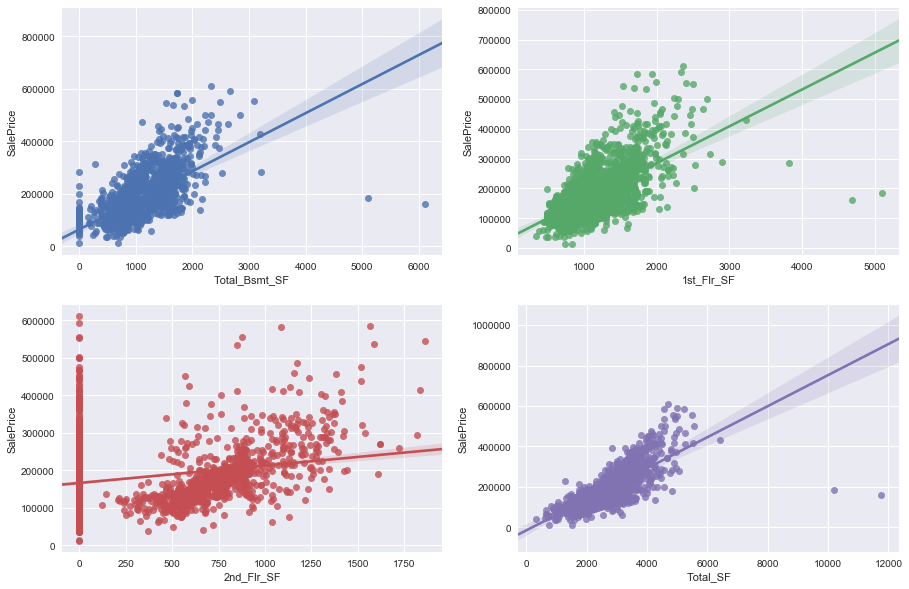

In [223]:
# Calculate Total surface 
data['Total_SF'] = data['Total_Bsmt_SF'] + data['1st_Flr_SF'] + data['2nd_Flr_SF']

# Plot each component and the result
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
sns.regplot(x='Total_Bsmt_SF', y='SalePrice', data=data, ax=ax[0][0])
sns.regplot(x='1st_Flr_SF',    y='SalePrice', data=data, ax=ax[0][1])
sns.regplot(x='2nd_Flr_SF',    y='SalePrice', data=data, ax=ax[1][0])
sns.regplot(x='Total_SF',      y='SalePrice', data=data, ax=ax[1][1])

As we can see from these plots, using the total surface reduces the scatter in the data points, and lets us clearly indentify the outliers.  Not only this, but it removes the issue of super expensive houses with no basement.  Note there should be other features that indicate whether the house has a basement or second floor.

#### `porch_area`
This is the same idea as for the total surface.  Actually, I got the idea of the total surface because I was thinking there were too many different kinds of porches.  So here is a new feature, which is the sum of the surface area of all the different kinds of porches : <br>
- `porch_area` = `Open_Porch_SF` + `Enclosed_Porch` + `3Ssn_Porch` + `Screen_Porch`

Let's take a look at the plots :


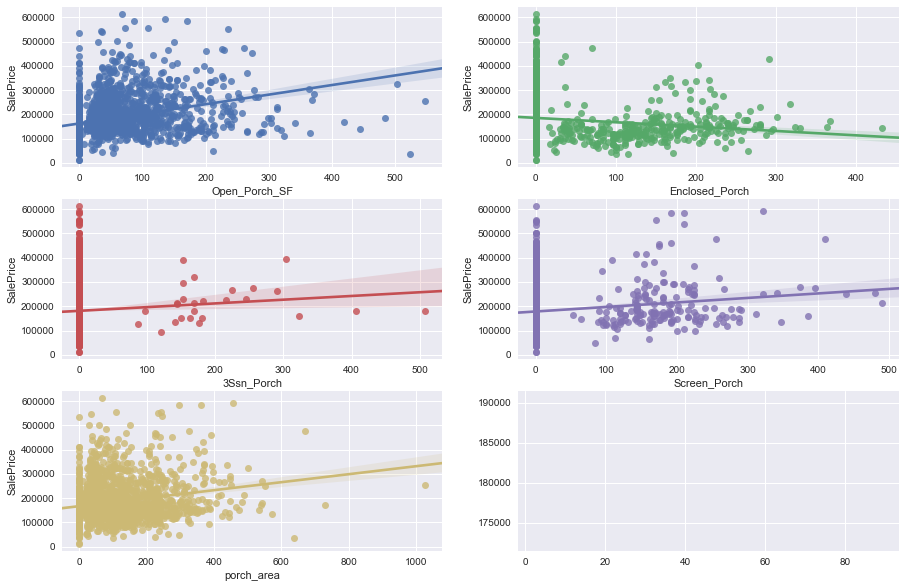

In [224]:
# Calculate Total surface 
data['porch_area'] = data['Open_Porch_SF'] + data['Enclosed_Porch'] + data['3Ssn_Porch'] + data['Screen_Porch']

# Plot each component and the result
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
sns.regplot(x='Open_Porch_SF',  y='SalePrice', data=data, ax=ax[0][0])
sns.regplot(x='Enclosed_Porch', y='SalePrice', data=data, ax=ax[0][1])
sns.regplot(x='3Ssn_Porch',     y='SalePrice', data=data, ax=ax[1][0])
sns.regplot(x='Screen_Porch',   y='SalePrice', data=data, ax=ax[1][1])
sns.regplot(x='porch_area',     y='SalePrice', data=data, ax=ax[2][0])

So it's not quite as nice as getting the total surface area.  There seems to be little correlation, and many of the houses don't have any porch.  To peak at what's ahead, this feature is likely to be dropped with feature selection, but I still wanted to include it here. 

#### `Overall_Qual2`

This new feature is simply the square of the `Overall_Qual` rating.  The reason for this, and it did improve my scores, can again be seen from a plot (I love plots):

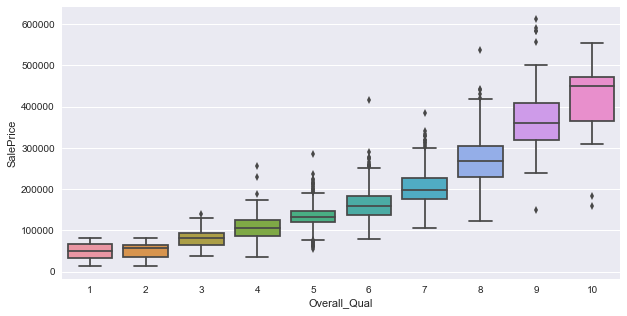

In [225]:
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='Overall_Qual', y='SalePrice', data=data, ax=ax)

So the reason I included this polynomial feature, is because when looking at the boxplot/average `SalePrice` for each `Overall_Qual` category, there seems to be some kind of quadratic relationship (the curve in the increase of `SalePrice`).  

### 3.3) Droping Columns

After making new features, I thought it was only fair to delete some.  So here is the list of features I've deleted, and the reason behind it :

- `Id` and `PID`.  These don't mean anything, and I didn't want my code to consider them when looking for numerical features.
- `Total_Bsmt_SF`, `1st_Flr_SF`, `2nd_Flr_SF`, because I combined them into `Total_SF`. 
- `Garage_Cars` because how many cars you can fit in a Garage is essentially the same thing as the Garage's surface area (which is a nother feature).
- `Pool_Area`, and `Pool_QC`, because there aren't enough houses with pools to make a decent model.
- `Kitch_AbvGr` because the grand majority of houses only had 1 Kitchen above ground.
- `Alley`, `Misc_Feature`, and `Fence` because there were not enough examples. 
- The different Porch features, since I combined them into Feature

### 3.4) Creating Dummy Variables

After a few model tests with only the numerical features, I started including some categorical ones by creating dummy columns (boolean indicators).  I'll be honest, none of these seem to improve my model, but they didn't make it worse either.  The columns I converted to dummies are :<br>
- `Neighborhood`
- `Bldg_Type`
- `MS_Zoning`
- `MS_SubClass`

The reason for these choices is because they did seem to have an effect on the `SalePrice`, but nothing obvious, so I couldn't just split it into two different categories.  For example, here's a box plot of the different neighborhoods :

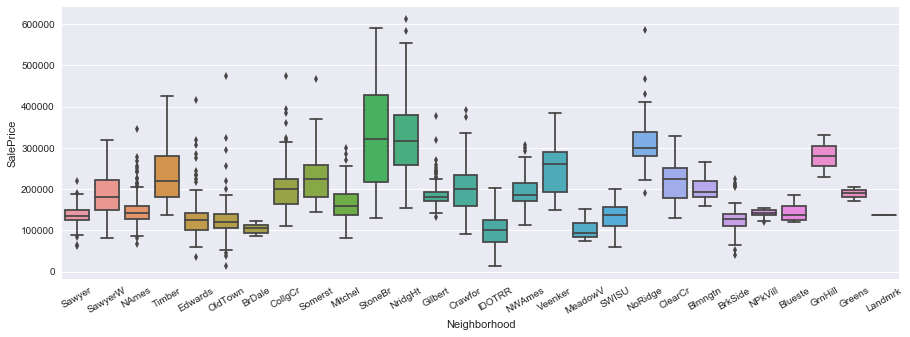

In [159]:
f, ax = plt.subplots(figsize=(15, 5))
g = sns.boxplot(x='Neighborhood', y='SalePrice', data=data, ax=ax)
ticks = ax.get_xticklabels();
ax.set_xticklabels(ticks, rotation=30);

From the above figure, we can see that different neighborhoods have different prices.  It could be because of the type of houses, but in the end we will let sklearn pick the best features.

## 4) Cleaning the Data / Preprocessing

After orginazing the data as we want it, there are few things left to do before actually making the models :<br>
- Identifying outliers, and removing them from the set.
- Imputing for Null values (using `sklearn.preprocessing.Imputer`)
- Scaling predictor columns (using `sklearn.preprocessing.StandardScaler`)

### 4.1) Identifying Outliers
Outliers were identified simply by plotting distributions of different features, and seeing if anything looks out of the ordinary.  That is the point does not seem representative of the data as a whole.  It is not a robust method, and certainly wouldn't be possible with huge data sets, so I'm sure some were missed, but that's what we've got.  Also, since there are not that many rows in the data set, I did not want to eliminate too many of them.

** Side Note ** <br> 
For quick look up of distributions and such, I used this function (found in `tools.py`):

In [160]:
def check_values(series, cat=True, bins=30) :
    # Check number of null values and 
    # Unique values for categorical data
    
    # Get data type and number of null values
    print("Dtype : ", series.dtype)
    print("N_null = ", series.isnull().sum())
    
    # Conditional display
    if (cat):
        # Categorical Feature
        # Print different categories, and the most common one.
        print("Unique : ", series.unique())
        print('mode :', stats.mode(series).mode[0])
        
        # If categorical data, make barplot with counts
        # for each category
        series.value_counts().plot(kind='bar')

    else:
        # Numerical data
        print('mean :', np.mean(series))
        print('median :', np.median(series))
        print('mode :', stats.mode(series).mode[0])
        
        # If Non_Categorical Data, make histogram
        ax = series.hist(bins=bins)
        ax.set_xlabel(series.name)
        ax.set_ylabel('Count')
   
    pass

#### `SalePrice`

Dtype :  int64
N_null =  0
mean : 181469.70160897123
median : 162500.0
mode : 130000


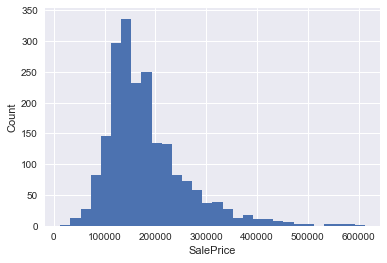

In [161]:
check_values(data.SalePrice, cat=False)

The distribution of the `SalePrice` has quite a long tail, and we see that there are a few wanderers betweent 500k and 600k.  In my models, I considered sale prices above 500k as outliers.  So I deleted those rows.

#### `Total_SF`

We saw before that there were some clear ouliers when looking at the total surface area.  But, for fun, let's look at the distribution :

Dtype :  float64
N_null =  1
mean : 2552.0965853658536
median : nan
mode : 1728.0


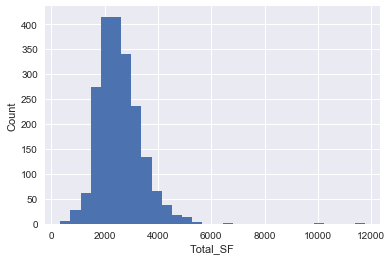

In [162]:
check_values(data.Total_SF, cat=False)

There are two points that are way out there (around 10000 ft$^2$, and 12000 ft$^2$)  These were considered outliers and have been omitted.

#### `Lot_Frontage`

Dtype :  float64
N_null =  330
mean : 69.05520046484602
median : nan
mode : 60.0


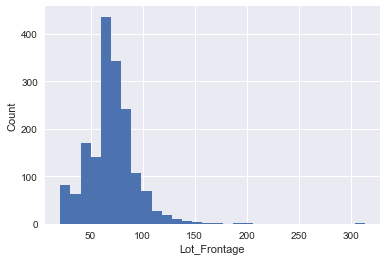

In [163]:
check_values(data.Lot_Frontage, cat=False)

Same idea here, we've deleted any row with a value below 250.  Which is just one value.  We also notice that there are a lot of null values in Lot_Frontage.  I guess it's a bit ambiguous to as to when you decide to just drop the column, but in this case I decided that there were enough of them to just fill in the Null values with the median value.

#### `Lot_Frontage`

Dtype :  int64
N_null =  0
mean : 10065.20819112628
median : 9430.0
mode : 9600


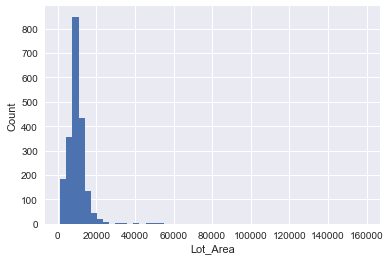

In [164]:
check_values(data.Lot_Area, cat=False, bins=50)

This plot was not so easy to see, so let's take a look at the scatter plot (with `SalePrice`).

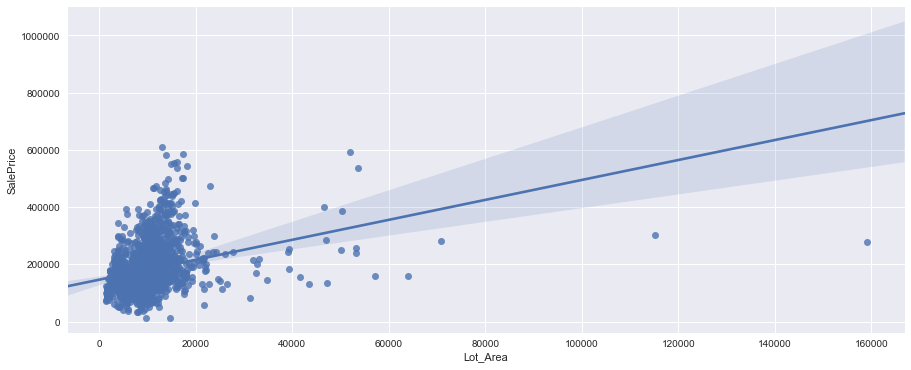

In [165]:
f, ax = plt.subplots(figsize=(15,6))
sns.regplot(x='Lot_Area', y='SalePrice', data=data, ax=ax)

Here we see that the `Lot_Area` feature is moslty clustered in a certain area, but there are quite a few points that go out of of the cluster.  Again, this is a little ambiguous, so I went with a cut off at 50000 ft$^2$. <br><br>

That was about it for outliers.  Again, I am sure there are others, and we could have implemented some code to automatically detect and remove outliers, but I didn't want to reduce the dataset to nothing.

### 4.2) `sklearn.preprocessing`

Now that the data has been organized and outliers have been deleted we can use `sklearn` to do some preprocessing. Methods used are fairly standard, but here it is:

** `Imputer` ** <br>
  For this, I just used the `Imputer` and used a `median` strategy.  Originally I decided on the strategy for each different column, and created a dictionary of Imputer objects.  This got a little confusing , and the results were not that different, so I decided to drop that method.
<br><br>
** `StandardScaler` ** <br>
I did not attempt anything fancy on this one, and just used the default scaling method in `sklearn` .

## 5) Regression Models 

Now it's time to jump into the models, and the code.  Again, I included some snippets in the introduction, but I will be starting from scratch here (Mostly so I don't have to scroll up and down).  I attempted three different types of regression models from the `sklearn` library : <br>
- LinearRegression
- Ridge
- Lasso
- GradientBoostingRegressor

In the end `GradientBoostingRegressor` gave me the best score (on Kaggle), so I will only be discussing that one.  But before going any further, let's set up our data :

I "start" by setting up a function to do all the cleaning as described above :

In [311]:
def clean(df):
    # Do all basic cleaning.
    # Meaning it's the same for both the training and testing data
    
    # Map scale categorical data to numbers
    df = map_to_number(df)
    
    # Transform / create columns
    df['MS_SubClass'] = df.MS_SubClass.apply(lambda x: str(x))
    df['Total_SF']      = df['Total_Bsmt_SF'] + df['1st_Flr_SF'] + df['2nd_Flr_SF']
    df['porch_area']    = df['Open_Porch_SF'] + df['Enclosed_Porch'] + df['3Ssn_Porch'] + df['Screen_Porch']
    df['Overall_Qual2'] = df['Overall_Qual']**2
    
    # Drop columns we don't want to keep
    df.drop(['Open_Porch_SF', 'Enclosed_Porch', '3Ssn_Porch', 'Screen_Porch'], axis=1, inplace=True)
    df.drop(['Total_Bsmt_SF', '1st_Flr_SF', '2nd_Flr_SF'], axis=1, inplace=True)
    df.drop('Garage_Cars', axis=1, inplace=True)
    df.drop('Pool_Area',   axis=1, inplace=True)
    df.drop('Kitchen_AbvGr', axis=1, inplace=True)
    df.drop(['Id', 'PID'], axis=1, inplace=True)
    df.drop(['Alley', 'Misc_Feature', 'Fence'], axis=1, inplace=True)   

    # Create dummy variables for some categorical data
    df = pd.get_dummies(df, columns=['MS_SubClass'])
    df = pd.get_dummies(df, columns=['Neighborhood'])
    df = pd.get_dummies(df, columns=['Bldg_Type'])
    df = pd.get_dummies(df, columns=['MS_Zoning'])
    
    # return the newly organized DataFrame
    return df

With this function defined, we can easily throw in the testing data later on.  Now we do everything that can/should only be done on the training set.

In [226]:
# Load and clean data
data = tools.load_csv('../data/train.csv')
data = clean(data)

# Get rid of rows with outliers
# (only certain columns are looked at)
data = data[data['SalePrice']    < 500000]
data = data[data['Total_SF']     < 10000]
data = data[data['Lot_Frontage'] < 250]
data = data[data['Lot_Area']     < 50000]

# Split DataFrame into predictor, and target variables
y = data[['SalePrice']].copy()
X = data.drop('SalePrice', axis=1).copy()

# Because in the end we are only looking at numerical and
# boolean features, let's only keep those ones.

# list of numerical data types in DataFrame
num_types = [np.int64, np.uint8, np.float64]

# make list of column names that have numerical values
# and only keep those ones in X (predictors)
num_cols = [c for c in X.columns if X[c].dtype in num_types]
X = X[num_cols]

Next up is splitting our data into training and testing.  I know we have the other file, `test.csv`, but it doesn't have the values for `SalePrice` or `Sale_Condition`, so it doesn't let us evaluate how well our model does on new data.  Once the data is split, we use `Imputer()` class to fill null values, and the `StandardScaler()` class to ... scale the data!

In [227]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocessing : doing training and testing here so it's in the same spot

# Use Imputer to fill null values
imputer = Imputer(strategy='median').fit(X_train)
X_train = imputer.transform(X_train)
X_test  = imputer.transform(X_test)

# Use StandardScaler to center and scale data to the same order of magnitude.
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

### 5.0.1) Feature Selection
For feature selection I used the same method for all models : `sklearn.feature_selection.RFE`.  To get an idea of how well it would predict the test set I defined the following function :

In [265]:
def see_KFeatures(X_train,  X_test, y_train, y_test, M=LinearRegression(), kmax=None, selection='rfe'):
    # Function to visualize how well K-features will do in a given model (M), using RFE.
    # Notation : 1 = train set, 2 = test set    
    
    # Make copy of variables (make sure we're not doing any permanent changes)
    X1 = X_train.copy()
    X2 = X_test.copy()
    y1 = y_train.copy()
    y2 = y_test.copy()
    
    # Define empty lists to store scores for K-features
    scores1 = []
    scores2 = []
    
    # Define list of K-features in range 1 
    # to the number of columns in the dataset
    if kmax == None:
        kmax = X1.shape[1] + 1
        
    ks = [i for i in range(1, kmax)]
    
    # Loop to train model with k-best features.
    # Cross validate to get score on training set
    # use model to get score on testing_set
    for k in ks:

        # Create selector object and fit to training data 
        if (selection=='rfe'):
            selector = RFE(M, n_features_to_select=k, step=2)
        else:
            selector = SelectKBest(k=k)
            
        selector.fit(X1, y1)

        # Transform training and teting data
        X1_new = selector.transform(X1)
        X2_new = selector.transform(X2)

        # Cross validate using given model
        cvs = cross_val_score(M, X1_new, y1, cv=3)

        # Fit model with subset of data
        M.fit(X1_new, y1)
        
        # Append mean of cross validation for training scores
        # Use score method to get one for testing data
        scores1.append(cvs.mean())
        scores2.append(M.score(X2_new,y2))
        
    # Save best number of features for testing and training
    best_train = ks[scores1.index(max(scores1))]
    best_test  = ks[scores2.index(max(scores2))]

    # Plot scores as a function of number of features
    f, ax = plt.subplots()
    ax.plot(ks, scores1, 'green')
    ax.plot(ks, scores2, 'blue')
    ax.set_xlabel('K-Features')
    ax.set_ylabel('Score')
    ax.legend(['train', 'test'])
    ax.set_title('Method :' + selection)
    
    # Print best results
    print('best train k: ',  best_train)
    print('best test k: ',  best_test)
   
    # Return best number for testing and training
    return [best_train, best_test]

This function basically runs through all possible values of $K$, so 1 feature to the total number of columns in a dataset.  For each of these it gets the best features for a given model (e.g : `GradientBoostingRegressor` ), reduces the trainind and testing data, fits the model to the training data, and finally gets the score for testing and training data.  Note that the score for the testing set is cross-validated.  Also note that we can do this with RFE or SelectKFeatures.  The reason I implemented this is because RFE was giving me wacky numbers with feature selection.

### 5.1) The Model : `GradientBoostingRegressor`
Now we can finally start looking at the model.
<br><br>
** Feature Selection ** <br>
Let's run our code to see the number of features we should keep in our Model!
<br><br>
**NOTE :** This function takes a while to run (~10-20 minutes)

best train k:  38
best test k:  44


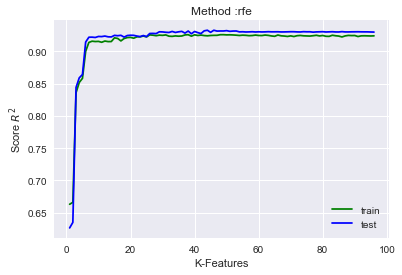

In [121]:
Ktrain, Ktest = see_KFeatures(X_train, X_test, y_train, y_test,
                              GradientBoostingRegressor(),
                              kmax=None,
                              selection='rfe')

So from this, we can see that only about 20 features are necessary to make ... more or less accurate predictions.  The improvement of the scores quickly flattens.  The actual peak on the test data is at 44, but there is virutally no difference, and may be attributed to random chance.  As a compromise, I will be using the best 30 features.

In [229]:
# Define estimator
estimator = GradientBoostingRegressor()

# Define/fit selector using RFE, and set to 30 features to keep
selector = RFE(estimator, n_features_to_select=50, step=2)
selector.fit(X_train, y_train)

# Transform training and testing data
X1 = selector.transform(X_train)
X2  = selector.transform(X_test)

** Grid Search **
<br>
Before Actually making the model, we run a gridsearch on the different parameters and get the best ones.
<br><br>
*Note: these parameters seem to vary a lot based on what rows are in my testing and training set.  It the end they didn't seem to make a huge difference, so I am showing this mostly for the sake of completion*

In [230]:
# Define model parameter ranges
params = {'n_estimators': [10 ,50, 75],
          'learning_rate': [0.45, 1.0],
          'alpha' : [0.1, 0.5, 0.9],
          'max_depth' : [2]
         }

# Define estimator and run grid search
estimator = GradientBoostingRegressor()
GSV = GridSearchCV(estimator, param_grid=params, n_jobs=-1)
GSV.fit(X1, y_train)

# Save dictionary of best parameters
best = GSV.best_params_
print(best)

{'alpha': 0.1, 'learning_rate': 0.45, 'max_depth': 2, 'n_estimators': 75}


** Making the Model **
<br>
Now that we have our best features and our "best" parameters, we can finally make the model, and test it out on the testing data.

In [231]:
# Make GradientBoostingRegressor object, using best parameters
M = GradientBoostingRegressor(n_estimators=best['n_estimators'],
                              max_depth=best['max_depth'],
                              alpha=best['alpha'],
                              learning_rate=best['learning_rate'],
                             )
#M = GradientBoostingRegressor()

# Show mean score of cross validation on training set
print(cross_val_score(M, X_train, y_train, cv=3).mean())

# Fit the model to the training data 
M.fit(X1, y_train)

# Get score, and predictions of testing set
print(M.score(X2, y_test))
predictions = M.predict(X2)

0.905404717016
0.920282632499


Sooo... Not the best model in the end. But that's okay.  Let's take a look at the predictions, versus the actual sale price :

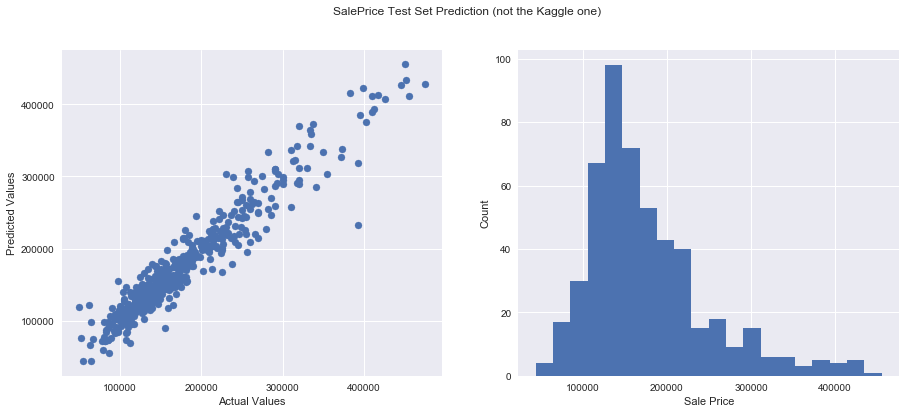

In [236]:
f, ax = plt.subplots(ncols=2, figsize=(15,6))
f.suptitle('SalePrice Test Set Prediction (not the Kaggle one)')
ax[0].scatter(x=y_test, y=predictions)
ax[0].set_ylabel('Predicted Values');
ax[0].set_xlabel('Actual Values');
ax[1].hist(predictions, bins=20)
ax[1].set_xlabel('Sale Price');
ax[1].set_ylabel('Count');

Well looking at the plot, it doesn't look so bad.  A fairly straight line, one point is way off, but the others seem to be a tight fit.  The distribution looks pretty similar to the original one as well.

### 6) Final Predictions (for Kaggle)

We have to run the set up code a little differently for the kaggle test data.  For one thing, we need to save the Id's of the predictions.  Also, it doesn't have `SalePrice` or `Sale_Condition`.  But without further ado, let's see what the predictions are!

In [238]:
# Load data
data_test = tools.load_csv('../data/test.csv')

# Save Id column, to be concatenated to predictions later.
ids = data_test[['Id']].copy()

# Basic cleaning
data_test = clean(data_test)

# Some Features didn't come out when making dummy columns.
# So I have manually make them, and set all values to zero
data_test['Neighborhood_GrnHill'] = 0
data_test['Neighborhood_Landmrk'] = 0
data_test['MS_Zoning_A (agr)']   = 0
data_test['MS_SubClass_150']   = 0

# Transform data with previously created objects
X_final = data_test[num_cols]
X_final = imputer.transform(X_final)
X_final = scaler.transform(X_final)
X_final = selector.transform(X_final)

# Make Predictions and store them into a data frame!
y_final = pd.DataFrame(M.predict(X_final), columns=['SalePrice'])


# Make concatenate predictions and Id's, and save to csv file
final_df = pd.concat([ids, y_final], axis=1)
final_df.to_csv('regression_final_submission.csv', index=False)

Before moving on to categorization let's take a quick look at the results.  We don't have a way to score the final test data, but we can at least look at the distribution, and summary statistics.

In [239]:
y_final.describe()

,SalePrice
count,879.000000
mean,179889.642559
std,76857.725328
min,34804.611697
25%,129762.416622
50%,159345.252248
75%,206459.296729
max,540388.255650


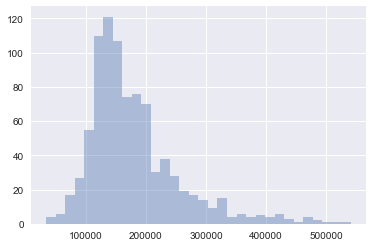

In [240]:
sns.distplot(y_final, kde=False)

** Final Thought on Regression Challenge **
<br>
The distribution seems pretty similar to the original one, so that's a good thing.  I didn't do too well on the Kaggle rankings, so I think I must be missing something.  Perhaps I should have made different choices in terms of which dummy columns to get in the dataframe.  Or maybe a different model in general would have been better.  Those are the only things I can think of since it seemed as thought no matter how much I tweaked the parameters, the results didn't improve much.

## Categorization Challenge

Copy pasted from Kaggle, here is what we have to do for this challenge :
1. Classify the `Sale Condition` value as abnormal or not.
2. Transform this feature so that 1=abnormal and 0=not abnormal.
<br><br>
Alright, I'll be completly honest, I spent waaaay too much time on regression and tweaking, and analysing.  So I don't have much time left for doing the Categorization part.  On that note, I'll only be doing one model, and I will keep the data as it was organized for the regression one.  Also, be warned that this part will be a lot less visual... I'm not sure how to represent categorical predictions graphically.  But I can, and will get the confusion matrix.  
<br><br>
On that note... let's get started by reloading / cleaning the data.  Here I'm just copying the cell from above, and making a few tweeks to use `Sale_Condition` as y (as a boolean).

In [296]:
# Load and clean data
data = tools.load_csv('../data/train.csv')
data = clean(data)

# Get rid of rows with outliers
# (only certain columns are looked at)
data = data[data['Total_SF']     < 10000]
data = data[data['Lot_Frontage'] < 250]
data = data[data['Lot_Area']     < 50000]

# Make target variable (boolean), and get predictors
y = data['Sale_Condition'].apply(lambda x: 1 if x =='Abnorml' else 0)
X = data.drop('SalePrice', axis=1) # Still have to drop since it's not in the final set.
X = data.drop('Sale_Condition', axis=1)

# Because in the end we are only looking at numerical and
# boolean features, let's only keep those ones.

# list of numerical data types in DataFrame
num_types = [np.int64, np.uint8, np.float64]

# make list of column names that have numerical values
# and only keep those ones in X (predictors)
# Different than before : have to take SalePrice out of the equation
# Since it's not in the test set.
num_cols = [c for c in X.columns if X[c].dtype in num_types and c != 'SalePrice']
X = X[num_cols]

Let's make sure we split into training and testing, Impute, and Scale :

In [297]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9001)

# Preprocessing : doing training and testing here so it's in the same spot

# Use Imputer to fill null values
imputer = Imputer(strategy='median').fit(X_train)
X_train = imputer.transform(X_train)
X_test  = imputer.transform(X_test)

# Use StandardScaler to center and scale data to the same order of magnitude.
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

### Choice of Model : Support Vector Classification

** Feature Selection **
<br>
As for the Regression model, I will see what kind of scores I get
with different numbers of features.  I might have to change the kernel, but apparently my function only works with a linear one.  It should still give us a good idea.

best train k:  1
best test k:  1


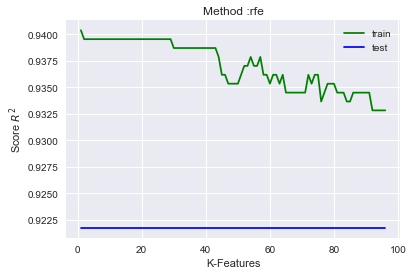

In [260]:
Ktrain, Ktest = see_KFeatures(X_train, X_test, y_train, y_test,
                              SVC(kernel='linear'),
                              kmax=None,
                              selection='rfe')

Well this is an intersting result... It actually seems wrong.  If I were to trust this, it would mean that we only need 1 feature to accurately predict whether or not the sale was abnormal. Let's take a look at this again, but using `SelectKBest`.

best train k:  1
best test k:  1


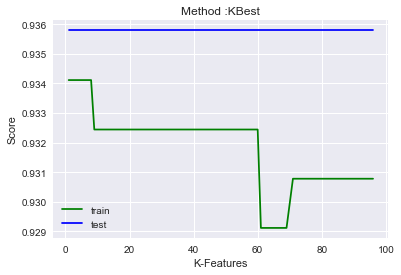

In [290]:
Ktrain, Ktest = see_KFeatures(X_train, X_test, y_train, y_test,
                              SVC(kernel='linear'),
                              kmax=None,
                              selection='KBest')

Well... I'm at a loss.  Either RFE/SelectKBest doesn't do what I think it does, or my function has a mistake, or my testing set is immune to the number of features selected.  In any case, I have to move on, so I'm just going to **keep all features**.

### Let's Make the Model : Support Vector Classification, using all features.

** Grid Search ** <br>
Let's do a quick grid search over different parameters of SVC :

In [291]:
# Before that, let's make a copy of my data
X1 = X_train.copy()
X2 = X_test.copy()
y1 = y_train.copy()
y2 = y_test.copy()

# Define model parameter ranges
params = {'C': [0.5, 1.0, 1.5],
          'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
          'degree' : [2, 3, 4],
          'shrinking' : [True, False]
         }

# Define estimator and run grid search
estimator = SVC()
GSV = GridSearchCV(estimator, param_grid=params, n_jobs=-1)
GSV.fit(X1, y1)

# Save dictionary of best parameters
best = GSV.best_params_
print(best)

{'C': 0.5, 'degree': 2, 'kernel': 'poly', 'shrinking': True}


So those are our best features.  Let's roll with it.

** Let's make the model (for real this time) **

In [298]:
# Define model 
M = SVC(C=0.5, degree=2, kernel='poly', shrinking=True)
 
# Fit to training data
M.fit(X1, y1)

# Print scores for training and testing data
# Cross validate for training
cvs = cross_val_score(M, X1, y1, cv=3)
print(cvs.mean())
print(M.score(X2, y2))

0.935785015323
0.93579766537


93 % Accuracy... not too shabby.  Credit goes to `sklearn` and its efficient library!
<br><br>
Before making predictions for the Kaggle competition, let's take a look at the confusion matrix (mostly for fun).

In [299]:
# Start by actually getting the predictions :
predictions = M.predict(X2)
matrix = confusion_matrix(y_true=y2, y_pred=predictions)
print(matrix)

[[480   1]
 [ 32   1]]


In a more redable format :
<br><br>

|    N = 514            | Predicted Normal  |  Predicted Abnormal |
|----------------|---------------|----------------|
| **Actual Normal**  |    480        |     1          |
| **Actual Abnormal** |     32        |     1          | 

Well that's embarassing.  My model basically predicted no for everything.  I take back what I said about the efficiency of `sklearn`.  This actually also explains why my feature selection graphs were out of wack.  Granted, there are not that many abnormal sales. So I think we can safely say that this is a useless model. Seeing as though I'm out of time though, I will not be making a new one.

** Predictions for Kaggle **
<br><br> 
Just copying and pasting code from above here (a few tweeks though)

In [308]:
# Load data
data_test = tools.load_csv('../data/test.csv')

# Save Id column, to be concatenated to predictions later.
ids = data_test[['Id']].copy()

# Basic cleaning
data_test = clean(data_test)

# Some Features didn't come out when making dummy columns.
# So I have manually make them, and set all values to zero
data_test['Neighborhood_GrnHill'] = 0
data_test['Neighborhood_Landmrk'] = 0
data_test['MS_Zoning_A (agr)']   = 0
data_test['MS_SubClass_150']   = 0

# Transform data with previously created objects
X_final = data_test[num_cols]
X_final = imputer.transform(X_final)
X_final = scaler.transform(X_final)

# Make Predictions and store them into a data frame!
y_final = pd.DataFrame(M.predict(X_final), columns=['Sale Condition'])

# Make concatenate predictions and Id's, and save to csv file
final_df = pd.concat([ids, y_final], axis=1)
final_df.to_csv('classification_final_submission.csv', index=False)

I can't do a confusion matrix without the answers.  Let's see what we predicted though :

In [307]:
print(final_df['Sale Condition'].value_counts())

0    876
1      3
Name: Sale Condition, dtype: int64


Three predictions out of 879 were abnormal... I don't know what the answers are but that doesn't seem too good.  If the percentage of abnormal values in the final data is the same as in the test data, then there should be about 60 abnormal values.  Based on that assumption, this is still a terrible model =\